<a href="https://colab.research.google.com/github/RushiKanjaria/Design-a-self-driving-car-solution-using-Reinforcement-Learning-using-Gym-Environment/blob/master/Self_Driving_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Design a self-driving car solution using Reinforcement Learning using Gym Environment
## 16th June 2020
#Created By: 
###Rushi Kanjaria, Marwadi University
###Kala Hemanth, Aditya Engineering College
###K. Jhansi Naga Indusri, V R Siddhartha engineering college
###Apoorva Jindal, Techno India NJR Institute of Technology
###Na-gasuri Alekhya, R.V.R & J.C College Of Engineering

## Mentored By: Dr. Hiren Takkar, Leadingindia.ai, Bennet University

#This project is a part of internship offered by leadingindia.ai

#Taxi-v3
```
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
```

####Description: 
There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

####Observations:
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.

####Passenger locations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)
- 4: in taxi

####Destinations:
- 0: R(ed)
- 1: G(reen)
- 2: Y(ellow)
- 3: B(lue)

####Actions:
There are 6 discrete deterministic actions:
- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

####Rewards:
There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.

####Rendering:
- blue: passenger
- magenta: destination
- yellow: empty taxi
- green: full taxi
- other letters (R, G, Y and B): locations for passengers and destinations


                           


###NOTE:
We have used google colab to impliment, train and test the self driving car. Google colab already contains the gym interface so you can skip step:0 and move on to step:1 if you are using google colab

#Step:0 Installing the gym interface



In [ ]:
!pip install cmake 'gym[atari]' scipy

#Step:1 Import the Libraries
First, We have to import some libraries, which will help us to create our agent.

In [54]:
import numpy as np          #Numpy is for our Qtable
import gym                  #OpenAI gym is for our environment, i.e., our Taxi Environment
import random               #Random is for generating random numbers

#Step:2 Create the Enviornment
 

*   We will use OpenAI Gym library to create our environment.
*   It is composed of many environments that we can use to train our agent.
*   We will be creating the Taxi environment.





In [55]:
env = gym.make("Taxi-v3")
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



#Step:3 Initialize the Hyperparameters

In [56]:
total_episodes = 50000          #Total episodes we will use to train our algorithm
total_test_episodes = 100       #Number of episodes we will use to test our algorithm
max_steps = 99                  #Maximum steps an agent can take during an episode

learning_rate = 0.7             #Learning rate
gamma = 0.6                     #Discount rate

#Exploration Parameters
epsilon = 1.0                   #Exploration rate
max_epsilon = 1.0               #Exploration probability at start(Max value the epsilon can have)
min_epsilon = 0.01              #Minimum exploration probability(min value the epsilon can have)
decay_rate = 0.01               #Exponential decay rate for exploration probability

#Solving the enviornment without Reinforcement Learning

In [57]:
env.reset()
total_epochs = []
total_penalties = []
total_reward = []
frames = []

for episode in range(total_test_episodes):
  state = env.reset()
  step = 0
  done = False
  epochs, penalties, reward = 0,0,0

  while not done:
    #env.render()
    action = env.action_space.sample()

    new_state, reward, done, info = env.step(action)

    if reward == -10:
      penalties += 1

    epochs += 1

    total_reward.append(reward)

    frames.append({'episode': episode, 'frames': env.render(mode='ansi'), 'state': state, 'action': action, 'reward': reward})

    state = new_state
  total_penalties.append(penalties)
  total_epochs.append(epochs)

#Visualizing the performance 

In [61]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        
        if i == 100:
          break

        print(f"Episode: {frame['episode']}")
        print(frame['frames'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.6)
        
        
        
print_frames(frames)

Episode: 0
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

Timestep: 100
State: 4
Action: 4
Reward: -10


In [62]:
print(f"Results after {total_test_episodes} episodes:")
print(f"Average timesteps per episode: {sum(total_epochs)/ total_test_episodes}")
print(f"Average reward per timesteps: {sum(total_reward) / sum(total_epochs)}")
print(f"Average penalties per episode: {sum(total_penalties) / total_test_episodes}")

Results after 100 episodes:
Average timesteps per episode: 198.85
Average reward per timesteps: -3.9102338446064873
Average penalties per episode: 64.37


In [63]:
avg_ts_nrl = sum(total_epochs)/ total_test_episodes
avg_reward_nrl = sum(total_reward) / sum(total_epochs)
avg_penalties_nrl = sum(total_penalties) / total_test_episodes

#Solving the environment with Reinforcement Learning

#Step:4 Create the Q-Table
*  To create our Qtable, we need to know how rows and columns we need, i.e., our states and actions. We have to calculate the action_size and state_size.
*  OpenAI Gym has a way to do that.

In [64]:
action_size = env.action_space.n        #returns how much actions our environment has
print("Action Size = ", action_size)

state_size = env.observation_space.n    #returns how much sate our environment has
print("State Size = ", state_size)

Action Size =  6
State Size =  500


In [65]:
qtable = np.zeros((state_size,action_size))     #Initializing our Qtable as a null matrix
print(qtable)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


#Step:5 Implement the Q learning algorithm
 **Q(s,a) ← Q(s,a) + α * [r + γ * maxa'Q(s',a') - Q(s,a)]**

*  α - Learning Rate
*  γ - Discout Rate

Breaking it down into steps, we get

*   Start exploring actions: For each state, select any one among all possible actions for the current state (s).
*   Travel to the next state (s') as a result of that action (a).
*   For all possible actions from the state (s') select the one with the highest Q-value.
*   Update Q-table values using the equation.
*   Set the next state as the current state.
*   If goal state is reached, then end and repeat the process.








In [66]:
for episode in range(total_episodes):
  #reset the environment
  state = env.reset()
  step = 0
  done = False

  for step in range(max_steps):
    #choose an action a in the current state
    #we first randomize a number
    exp_exp_tradeoff = random.uniform(0,1)

    #If this number is greater than epsilon, then we are in situation of exploitation (taking the biggest Q value for this state)
    if exp_exp_tradeoff > epsilon:
      action = np.argmax(qtable[state,:])

    #else we will do a random choice, i.e., exploration
    else:
      action = env.action_space.sample()

    #Now we are taking the action(a) and moving to the state(s') and getting the reward(r)
    new_state, reward, done, info = env.step(action)

    #We update our Qtable using the Qlearning equation
    qtable[state,action] = qtable[state,action] + learning_rate * (reward + gamma * (np.max(qtable[new_state, :])) - qtable[state,action])

    #Updating our state
    state = new_state

    #if done, then finish the episode
    if done == True:
      break
    
  #We reduce the epsilon (as we need less exploration)
  epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)



#Evaluate our agent

*   After 50,000 episodes, The training is finished and the updated Qtable has been genrated using Qlearning
*   This Qtable will help our agent to take right action at any state to maximize the reward
*  Now the next action is always selected using the best Qvalue



In [67]:
env.reset()
total_epochs = []
total_penalties = []
total_reward = []
frames = []

for episode in range(total_test_episodes):
  state = env.reset()
  step = 0
  done = False
  epochs, penalties, reward = 0,0,0

  while not done:
    #env.render()
    action = np.argmax(qtable[state,:])

    new_state, reward, done, info = env.step(action)

    if reward == -10:
      penalties += 1

    epochs += 1

    total_reward.append(reward)

    frames.append({'episode': episode, 'frames': env.render(mode='ansi'), 'state': state, 'action': action, 'reward': reward})

    state = new_state
  total_penalties.append(penalties)
  total_epochs.append(epochs)

#Visualizing the performance

In [68]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        
        if frame['episode'] == 10:
          break

        print(f"Episode: {frame['episode']}")
        print(frame['frames'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.6)
        
        
        
print_frames(frames)

Episode: 9
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 128
State: 97
Action: 5
Reward: 20


In [69]:
print(f"Results after {total_test_episodes} episodes:")
print(f"Average timesteps per episode: {sum(total_epochs)/ total_test_episodes}")
print(f"Average reward per timestep: {sum(total_reward) / sum(total_epochs)}")
print(f"Average penalties per episode: {sum(total_penalties) / total_test_episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.57
Average reward per timestep: 0.6706443914081146
Average penalties per episode: 0.0


In [70]:
avg_ts_rl = sum(total_epochs)/ total_test_episodes
avg_reward_rl = sum(total_reward) / sum(total_epochs)
avg_penalties_rl = sum(total_penalties) / total_test_episodes

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [72]:
models = [("Random agent's performance", avg_reward_nrl, avg_penalties_nrl, avg_ts_nrl),("Q-learning agent's performance", avg_reward_rl, avg_penalties_rl, avg_ts_rl)]

In [73]:
Algorithms = pd.DataFrame(data = models, columns=['Model', "Average rewards per move", "Average number of penalties per episode", "Average number of timesteps per trip"])

In [74]:
Algorithms

,Model,Average rewards per move,Average number of penalties per episode,Average number of timesteps per trip
0,Random agent's performance,-3.910234,64.37,198.85
1,Q-learning agent's performance,0.670644,0.00,12.57


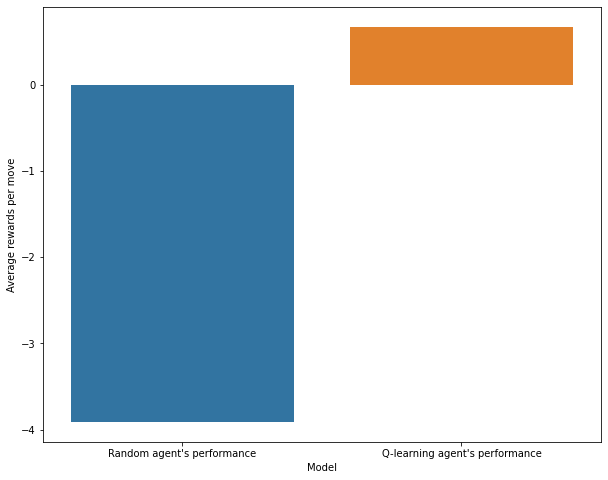

In [76]:
plt.figure(figsize=(10,8))

sns.barplot(x = 'Model', y = 'Average rewards per move', data = Algorithms)
plt.show()

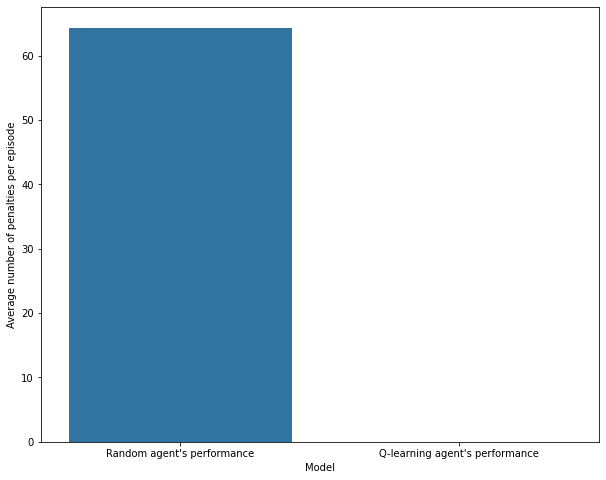

In [77]:
plt.figure(figsize=(10,8))

sns.barplot(x = 'Model', y = 'Average number of penalties per episode', data = Algorithms)
plt.show()

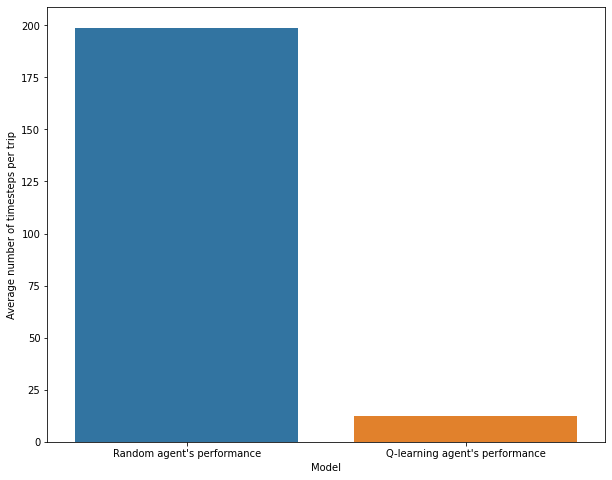

In [78]:
plt.figure(figsize=(10,8))

sns.barplot(x = 'Model', y = 'Average number of timesteps per trip', data = Algorithms)
plt.show()

#References


*   https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
*   https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Q%20learning/Taxi-v2/Q%20Learning%20with%20OpenAI%20Taxi-v2%20video%20version.ipynb
*  https://gym.openai.com/envs/Taxi-v3/
*  https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

